<a href="https://colab.research.google.com/github/charliexu07/Archaeological-Image-Classifier/blob/main/ImageClassifierResnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Archaeological Sites Image Classifier

This notebook contains the code to train an image classifier using the images in the `TaggedData` folder.

You can start by running this code as is an examining the results. To improve your results, you can make any of the following changes:
- **Architecture:** ResNet34 or ResNet50 (or anything else you would like to try).

- **Image size:** 64, 128, 256, 512, etc.... Here is some information about how fast.ai does image cropping: [Link](https://forums.fast.ai/t/understanding-how-image-size-is-handled-in-fast-ai/12330/4).

- **Transformations:** Consider horizontal flip or changes in lighting. The documentation to learn about all the transformations fast.ai has to offer is located here: [link](https://fastai1.fast.ai/vision.transform.html).

- **Learning rate:** 0.1, 0.01, etc.... You can use the `lr_finder` to get an idea of a good learning rate for your model. Let me know you have any questions about how to interpret the learning rate curve.

- **Fine-tuning:** `unfreeze()` and `unfreeze(n)` to unfreeze parts of the underlying architecture for fine-tuning. Remember to `freeze()` your model again when you are done fine-tuning.

- **Create an additional class:** If you notice that many of the images in `plot_top_losses()` are image frames before the bike enters the trail, you could try making a third class for these images as we discussed in the Zoom call.

## Set-up

In [ ]:
# !pip show fastai
# !pip install fastai==1.0.61

In [ ]:
# You will need to run this each time you restart the notebook.
!pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!ls '/gdrive/My Drive/Huo_Research/'

Resnet50.ipynb	TaggedData


In [ ]:
from fastai.vision import *
import pandas as pd
import os

## Model

#### Load data

In [ ]:
image_path = '/gdrive/My Drive/Huo_Research/TaggedData'
print(len(os.listdir(image_path)))

3


In [ ]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_folder(path=image_path)
        .split_by_folder(train='train', valid='valid')
        .label_from_folder()
        # .transform(get_transforms(do_flip=True, flip_vert=True, max_zoom=1.0, max_warp=0.0, xtra_tfms=[contrast(scale=(0.1, 0.2), p=1.)]), size=(128))
        .transform(get_transforms(do_flip=True, flip_vert=True, max_zoom=1.0, max_warp=0.0, xtra_tfms=[contrast(scale=(0.1, 0.5), p=0.5)]), size=(128))
        .databunch()
        .normalize())

In [ ]:
print(data.classes)

# Print the number of images in each class
print(len(os.listdir(os.path.join(image_path, 'train', 'building'))))
print(len(os.listdir(os.path.join(image_path, 'train', 'no_building'))))
print(len(os.listdir(os.path.join(image_path, 'valid', 'building'))))
print(len(os.listdir(os.path.join(image_path, 'valid', 'no_building'))))

['building', 'no_building']
258
4882
71
619


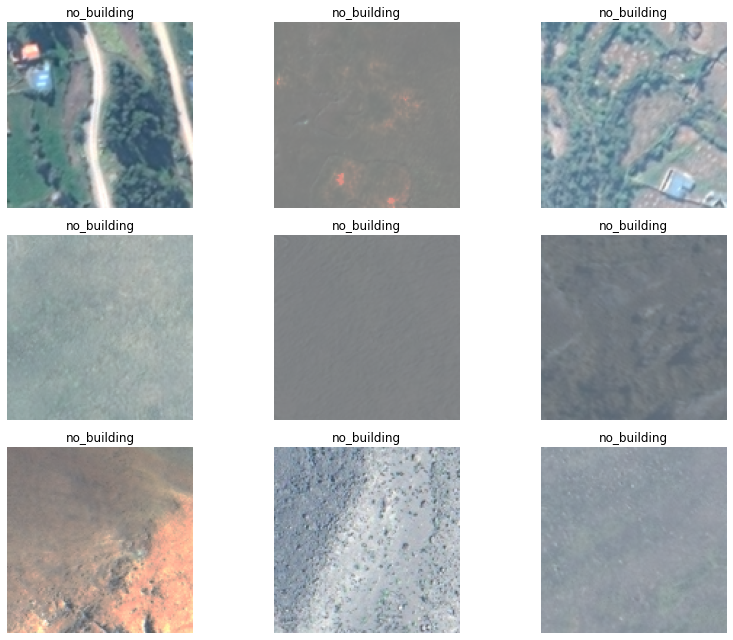

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet 50, size = 128

Download the model architecture.

In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy, error_rate])

In [ ]:
learn.model = learn.model.cuda()

Find a good learning rate.

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


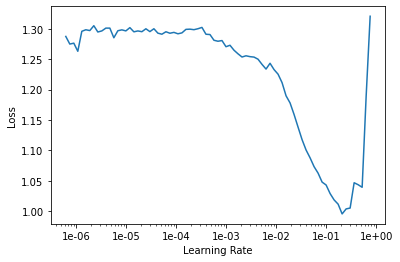

In [ ]:
learn.recorder.plot()

In [ ]:
# Set this to a good learning rate from learn.recorder.plot()
# Ask me if you have any questions about how to interpret the learning rate plot
lr = 0.1

Train the model with your learning rate.

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.406630,0.665770,0.895652,0.104348,00:27
1,0.477000,0.175496,0.934783,0.065217,00:28
2,0.248249,0.180654,0.936232,0.063768,00:28
3,0.163495,0.141856,0.946377,0.053623,00:28
4,0.134738,0.165776,0.931884,0.068116,00:28


Save the model.

In [ ]:
model_name = 'charlie_version_1' # change this to the name of your model, for example gabi_version_1

# learn.save(os.path.join(path, 'SavedModels', model_name))
learn.save(os.path.join('/gdrive/My Drive/Huo_Research/TaggedData/models', model_name))

Examine the learning curve of your model, the confusion matrix, and the top losses.

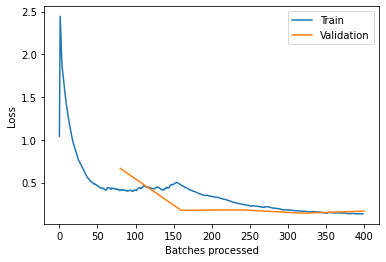

In [ ]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

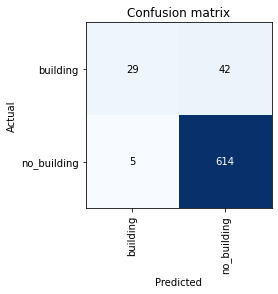

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
confusion_matrix = interp.confusion_matrix()

TP = confusion_matrix[0][0]
FP = confusion_matrix[1][0]
FN = confusion_matrix[0][1]
TN = confusion_matrix[1][1]

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print('Precision: %f \nRecall: %f \nAccuracy: %f'%(precision,recall,accuracy))

Precision: 0.852941 
Recall: 0.408451 
Accuracy: 0.931884


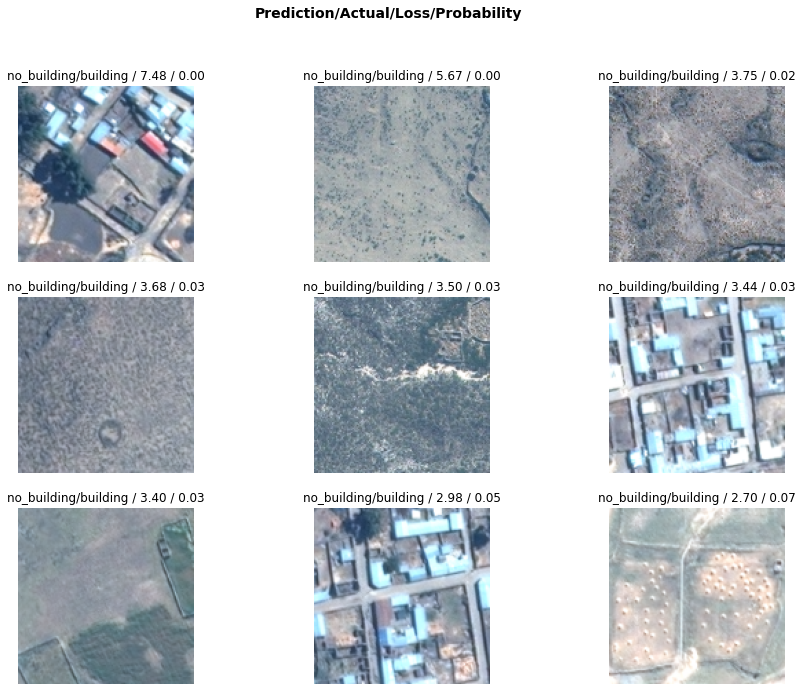

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

#### Unfreeze the model and fine-tune.

Load your saved model.

In [ ]:
# learn.load(os.path.join(path, 'SavedModels', model_name))
learn.load(os.path.join('/gdrive/My Drive/Huo_Research/TaggedData/models/', model_name))

Learner(data=ImageDataBunch;

Train: LabelList (5140 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
building,building,building,building,building
Path: /gdrive/My Drive/Huo_Research/TaggedData;

Valid: LabelList (690 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
building,building,building,building,building
Path: /gdrive/My Drive/Huo_Research/TaggedData;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Unfreeze the model and fine-tune.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


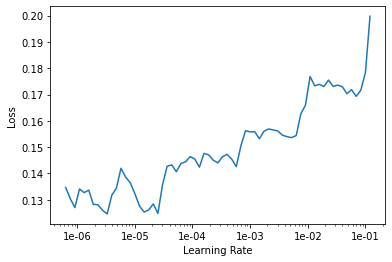

In [ ]:
learn.recorder.plot()

In [ ]:
# You can change the learning rates in slice.
# Use the learn.recorder.plot to find good parameters for max_lr.
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.122157,0.205351,0.934783,0.065217,00:29
1,0.119792,0.319719,0.939130,0.060870,00:29
2,0.111292,0.268349,0.940580,0.059420,00:29
3,0.106342,0.135515,0.950725,0.049275,00:29
4,0.112286,0.140525,0.947826,0.052174,00:29


In [ ]:
fine_tuned_model_name = 'charlie_fine_tuned_version_1'
# learn.save(os.path.join(path, 'SavedModels', fine_tuned_model_name))
learn.save(os.path.join('/gdrive/My Drive/Huo_Research/TaggedData/models', fine_tuned_model_name))

In [ ]:
learn.freeze()

Examine the learning curve of your model, the confusion matrix, and top losses.

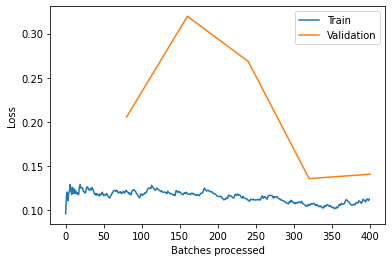

In [ ]:
learn.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

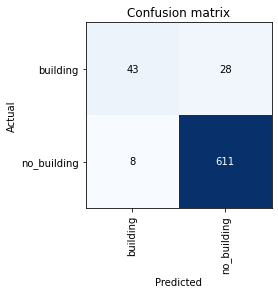

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
confusion_matrix = interp.confusion_matrix()

TP = confusion_matrix[0][0]
FP = confusion_matrix[1][0]
FN = confusion_matrix[0][1]
TN = confusion_matrix[1][1]

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print('Precision: %f \nRecall: %f \nAccuracy: %f'%(precision,recall,accuracy))

Precision: 0.843137 
Recall: 0.605634 
Accuracy: 0.947826


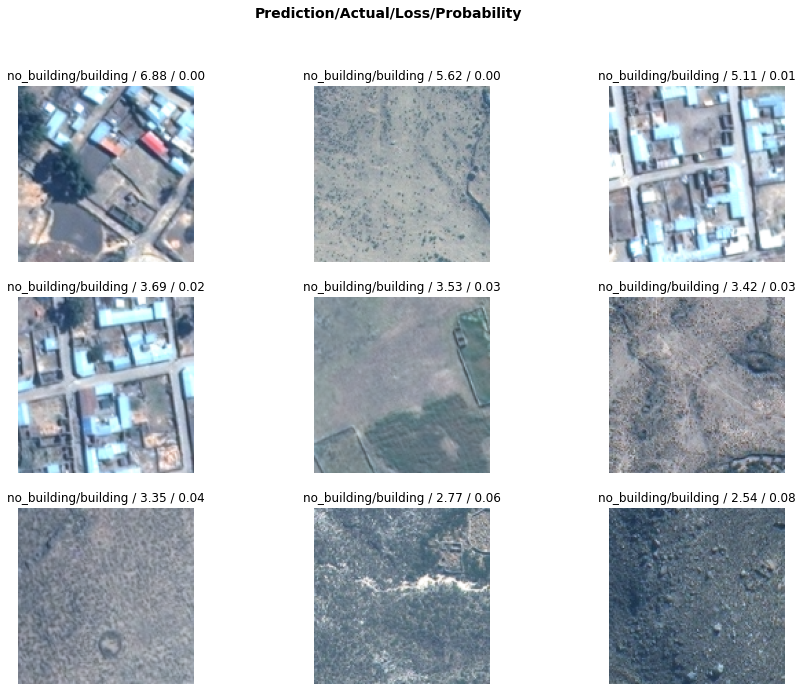

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))